In [8]:
import os
from datetime import datetime, timedelta
import xarray as xr
import scipy.signal as ss
from scipy.spatial import distance as dist
from scipy.ndimage import gaussian_filter, uniform_filter
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as ft
import numpy as np
import itertools
import pandas as pd
from collections import OrderedDict

In [9]:
era5_slp = xr.open_dataset('~/espr/era5/mslp.nc',chunks={'time':100,'latitude':100,'longitude':100})

In [22]:
class CentroidFinder:
    def __init__(self, ds, threshold=5, use_first_var=True, **kwargs):
        self.ds = ds
        self.threshold = threshold
        
        if use_first_var:
            self.da = self.ds[[n for n in ds.data_vars.keys()][0]]
        else:
            try:
                data_var = kwargs['data_var']
                self.da = self.ds[data_var]
            except:
                'variable data_var must be set if not using first available variable in xarray dataset'
        if 'resolution' in kwargs.keys():
            self.res = kwargs['resolution']
        else:
            self.res = 1
        self.dims = len(self.da.shape)
        
    ##to be put into utils file
    def detect_local_minima(self, arr):
        # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
        """
        Takes an array and detects the troughs using the local maximum filter.
        Returns a boolean mask of the troughs (i.e. 1 when
        the pixel's value is the neighborhood maximum, 0 otherwise)
        """
        # define an connected neighborhood
        # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
        neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
        # apply the local minimum filter; all locations of minimum value 
        # in their neighborhood are set to 1
        # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
        local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
        # local_min is a mask that contains the peaks we are 
        # looking for, but also the background.
        # In order to isolate the peaks we must remove the background from the mask.
        # 
        # we create the mask of the background
        background = (arr==0)
        # 
        # a little technicality: we must erode the background in order to 
        # successfully subtract it from local_min, otherwise a line will 
        # appear along the background border (artifact of the local minimum filter)
        # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
        eroded_background = morphology.binary_erosion(
            background, structure=neighborhood, border_value=1)
        # 
        # we obtain the final mask, containing only peaks, 
        # by removing the background from the local_min mask
        detected_minima = local_min ^ eroded_background
        return np.where(detected_minima)       

    def minima_filter(self, **kwargs):
        if self.dims == 2:
            if 'edge_radius' in kwargs.keys():
                edge_radius = kwargs['edge_radius']
                H1 = uniform_filter(self.da[edge_radius:-edge_radius,edge_radius:-edge_radius],size=10,mode='nearest')
            else:
                H1 = uniform_filter(self.da,size=10,mode='nearest')
            gradx,grady = np.gradient(H1)
            gradxx = np.gradient(gradx.copy())[0]
            gradyy = np.gradient(grady.copy())[1]
            gradxy = np.gradient(gradx.copy())[1]
        elif self.dims == 3:
            if 'edge_radius' in kwargs.keys():
                edge_radius = kwargs['edge_radius']
                H1 = np.array([uniform_filter(n[edge_radius:-edge_radius,edge_radius:-edge_radius],size=10,mode='nearest') for n in self.da])
            else:
                H1 = np.array([uniform_filter(n,size=10,mode='nearest') for n in self.da])
            gradx,grady = np.gradient(H1,axis=(1,2))
            gradxx = np.gradient(gradx.copy(),axis=(1,2))[0]
            gradyy = np.gradient(grady.copy(),axis=(1,2))[1]
            gradxy = np.gradient(gradx.copy(),axis=(1,2))[1]
        else:
            assert self.dims <= 3, 'filter requires dims <= 3'
        h = gradxx*gradyy - gradxy**2
        h_zero = h.copy()
        h_zero[h_zero < .05] = np.nan
        h_zero[gradxx < 0] = np.nan   
        h_zero[gradyy < 0] = np.nan   
        h_zero_coords = h_zero.copy()
        h_zero_coords[H1>101800] = np.nan
        h_zero_coords[h_zero_coords<np.nanquantile(h_zero_coords,.90)] = np.nan
        self.h_test = h_zero_coords
        return h_zero_coords
    
    def euclidian_mask(self, p1, p2):
        lat1 = float(p1[0])
        lat2 = float(p2[0])
        lon1 = float(p1[1] % 360)
        lon2 = float(p2[1] % 360)
        if abs(lat1-lat2) > self.threshold or abs(lon1-lon2) > self.threshold:
            return False
        else:
            dist = np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)
            return dist < self.threshold*4

    def filter_points(self, field, coord1, coord2):
        mins = np.maximum(field.sel(latitude=coord1[0],longitude=coord1[1]).values,
                         field.sel(latitude=coord2[0],longitude=coord2[1]).values)
        outs = [coord1,coord2][np.where([field.sel(latitude=coord1[0],longitude=coord1[1]).values,
                         field.sel(latitude=coord2[0],longitude=coord2[1]).values]==mins)[0][0]]
        return outs   

    def _create_coord_tuples(self, h, lat_map, lon_map):
        coords = self.detect_local_minima(-h)
        coords_ll = (lat_map[coords[0]],lon_map[coords[1]])
        coords_list = [(coords_ll[0][n],coords_ll[1][n]) for n in range(len(coords_ll[0]))]
        out_mask = [self.filter_points(self.da,*n) for n in\
                            itertools.combinations(coords_list,2) if self.euclidian_mask(*n)]  
        
        return [x for x in coords_list if x not in out_mask]
    
    def _test_plot(self, lats, lons, iteration=0):
        fig,ax = plt.subplots(figsize=(20,5),subplot_kw=dict(projection=ccrs.PlateCarree()))
        if self.dims == 3:
            quad1 = self.da[iteration].plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=50,cbar_kwargs={'spacing': 'proportional',
                                                                                          'fraction':0.02,'pad':0.01})
            contour = (self.da[iteration]/100).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=50,colors='k',linewidths=0.5)
        elif self.dims == 2:
            quad1 = self.da.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=50,cbar_kwargs={'spacing': 'proportional',
                                                                                          'fraction':0.02,'pad':0.01})
            contour = (self.da/100).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=50,colors='k',linewidths=0.5)
        plt.clabel(contour,fmt='%1.0f')
        scatter = ax.scatter(lons,lats,transform=ccrs.PlateCarree(),c='r')
        ax.coastlines()
        plt.show()    
        
    def identify_centroids(self, plot_map=False, **kwargs):
        if 'remove_edges' in kwargs.keys():
            if kwargs['remove_edges']:
                try:
                    edge_radius = int(np.round(kwargs['edge_radius']/self.res))
                except:
                    edge_radius = int(np.round(5/self.res))
                    
            h = self.minima_filter(edge_radius=edge_radius)
            lat_map = self.da.latitude.values[edge_radius:-edge_radius]
            lon_map = self.da.longitude.values[edge_radius:-edge_radius]
                    
        h = self.minima_filter()
        lat_map = self.da.latitude.values
        lon_map = self.da.longitude.values
        if self.dims == 2:
            coords_list = self._create_coord_tuples(h, lat_map, lon_map)
            lats = [n[0] for n in coords_list]
            lons = [n[1] for n in coords_list]
            if plot_map:
                self._test_plot(lats, lons)
        elif self.dims == 3:
            coords_list = [self._create_coord_tuples(n, lat_map, lon_map) for n in h]
            i=0
            for valid in coords_list:
                lats = [n[0] for n in valid]
                lons = [n[1] for n in valid]
                if plot_map:
                    self._test_plot(lats, lons,iteration=i)
                i+=1
        return coords_list
    
    def subset_time(self, period, iloc=False):
#         import pdb; pdb.set_trace()
        try:
            if len(period) == 1:
                if iloc:
                    self.da = self.da[period]
                else:
                    self.da = self.da.loc[period]
            else:
                if iloc:
                    assert isinstance(period[0], int), f'period must be int if using iloc'
                    assert len(period) == 2, f'period must have only two values'
                    self.da = self.da[period[0]:period[-1]]
                else:
                    assert len(period) == 2, 'period must have two values, beginning and end date'
                    self.da = self.da.loc[period[0]:period[-1]]
        except TypeError:
                if iloc:
                    self.da = self.da[period]
                else:
                    self.da = self.da.loc[period]
            
        self.dims = len(self.da.shape)
        
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


def cent(num_times):
    centroid = CentroidFinder(era5_slp,resolution=0.25)
    centroid.subset_time(num_times,iloc=True)
    coords_list = centroid.identify_centroids()
    return coords_list

def conv_to_filter(da):
    conv = ss.convolve2d(da,small_uniform,boundary='symm',mode='same')
    test_filter = conv.copy()
    test_filter[test_filter>np.quantile(test_filter,0.01)] = np.nan
    outs = detect_local_minima(test_filter)
    return test_filter, outs

def conv_kernel_array(filter_size_in_deg, model_res):
    array_size = int(filter_size_in_deg/model_res)
    kernel = np.ones((array_size,array_size))/array_size**2
    return kernel

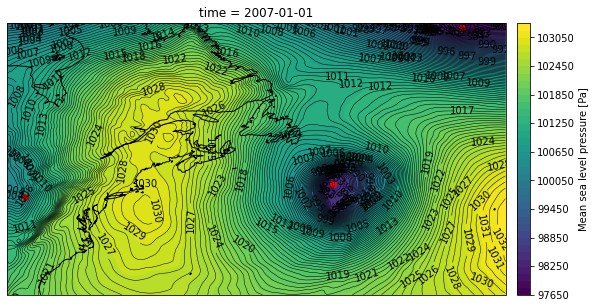

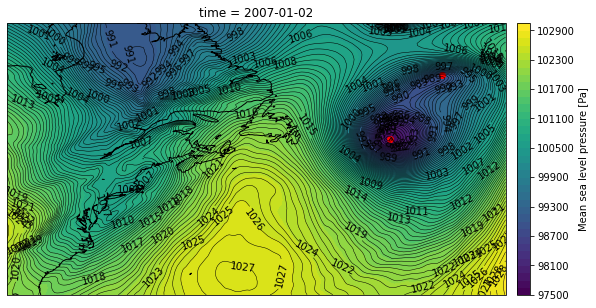

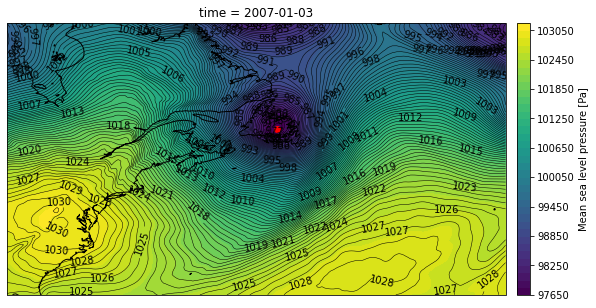

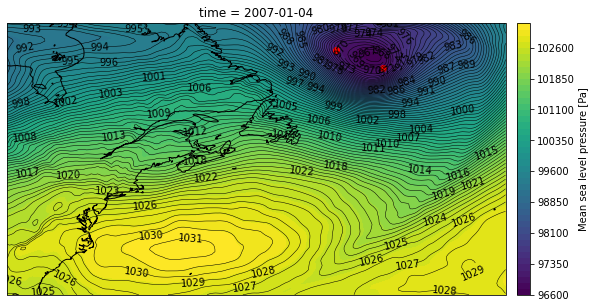

In [21]:
time = pd.date_range('2007-01-01', freq='D', periods=5)
centroid = CentroidFinder(era5_slp.sel(latitude=slice(60,30),longitude=slice(-85,-30),time=time),resolution=0.25)
centroid.subset_time(('2007-01-01','2007-01-04'))
coords = centroid.identify_centroids(plot_map=True,remove_edges=True,edge_radius=7.5)

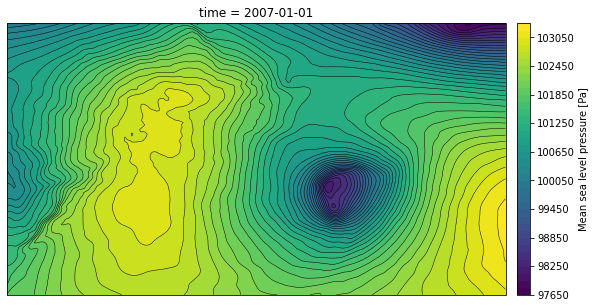

In [16]:
fig,ax = plt.subplots(figsize=(20,5),subplot_kw=dict(projection=ccrs.PlateCarree()))
quad1 = centroid.da[0].plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=50,cbar_kwargs={'spacing': 'proportional',
                                                                              'fraction':0.02,'pad':0.01})
contour = (centroid.da[0]/100).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=50,colors='k',linewidths=0.5)


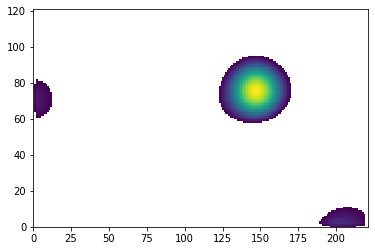

In [18]:
plt.pcolormesh(centroid.h_test[0])

In [49]:
import cProfile, pstats
centroid = CentroidFinder(era5_slp.sel(latitude=slice(60,30),longitude=slice(-85,-30),time=time),resolution=0.25)
centroid.subset_time(('2007-01-01','2007-01-02'))
# coords_list = centroid.identify_centroids()
profiler = cProfile.Profile()
profiler.enable()
centroid.identify_centroids(plot_map=False,remove_edges=True,edge_radius=7.5)
profiler.disable()


NameError: name 'pstats' is not defined